In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.conv_ae_1D import *
import torch
import random
from torchvision.transforms import transforms as T, Lambda
from pathlib import Path
from config import *
from utils import *
from conv_utils import *

import numpy as np
import platform
import json

architecture='conv_ae1D'

In [15]:
exp_dict = exp_name_folders(path =esa_exploration, architecture=architecture)
for k in exp_dict.keys():
    print('num selection:{} - exp name:{}'.format(k, exp_dict[k]))

num selection:0 - exp name:4_wheel_system_conv_ae1D_sl_40_fixed
num selection:1 - exp name:4_wheel_system_conv_ae1D_sl_16_fixed
num selection:2 - exp name:4_wheel_system_conv_ae1D_sl_40_flattened_1_increasing_1
num selection:3 - exp name:third_wheel_system_conv_ae1D_sl_16
num selection:4 - exp name:third_wheel_system_conv_ae1D_sl_40


In [16]:
select_exp = '1'
added_path = exp_dict[select_exp]
model_results_path = esa_exploration + '{}/{}'.format(architecture, added_path)
print('selected experiment:', added_path)

selected experiment: 4_wheel_system_conv_ae1D_sl_16_fixed


In [17]:
files = os.listdir(model_results_path)
model_list, summary = find_models(files, model_results_path)

summary path: /srv/penny/FIORIRE/time_series_anomaly_detection/model_results/esa_exploration/conv_ae1D/4_wheel_system_conv_ae1D_sl_16_fixed/summary.csv


In [18]:
summary.reset_index().head()

,index,Unnamed: 0,name,parameters_number,train_loss,val_loss
0,39,10,"trainCONVAE1D_c659d_00017_17_activation=Elu,ba...",25856,0.001769,0.000133
1,38,32,"trainCONVAE1D_c659d_00025_25_activation=Elu,ba...",38582,0.000925,0.000155
2,37,35,"trainCONVAE1D_c659d_00012_12_activation=Elu,ba...",49382,0.001760,0.000161
3,36,22,"trainCONVAE1D_c659d_00023_23_activation=Elu,ba...",21248,0.001436,0.000182
4,35,1,"trainCONVAE1D_c659d_00036_36_activation=Relu,b...",9797,0.001640,0.000398


In [19]:
rank = 0
model_name_path = select_by_rank(rank, model_results_path, summary)
model_name = summary.name.iloc[rank]
f = open(os.path.join(model_results_path, '/'.join(model_name_path.split('/')[:-2]), 'params.json'))
print('hyper-parameters')
print(json.load(f))

hyper-parameters
{'activation': 'Elu', 'batch_size': 500, 'dilation': 1, 'epochs': 200, 'filter_num': 64, 'flattened': 0, 'increasing': 0, 'kernel_size': 9, 'latent_dim': 100, 'lr': 0.001, 'lr_patience': 10, 'n_layers': 1, 'pool': 1, 'seq_in_length': 16}


In [20]:
checkpoint  = torch.load(os.path.join(model_results_path, model_name_path))

params_conf = checkpoint['param_conf']
cfg = checkpoint['cfg']

In [21]:
sm = str(torch.cuda.get_device_capability())
sm = ''.join((sm.strip('()').split(',')[0],sm.strip('()').split(',')[1])).replace(' ', '')

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")

In [9]:
if 'flattened' in params_conf.keys():
    flattened = flattened=params_conf['flattened']
else:
    flattened=False
    
model = CONV_AE1D(in_channel=params_conf['in_channel'],  length=params_conf['length']
                  , kernel_size=params_conf['kernel_size'], filter_num=params_conf['filter_num'],
                 n_layers=params_conf['n_layers'], activation = params_conf['activation']
                  , stride=params_conf['stride'], pool=params_conf['pool'],
                  flattened=flattened).to(device).float()
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
par_nums = count_parameters(model)
print('number of params', par_nums)

Initializing conv2d weights with Kaiming He normal
Initializing conv2d weights with Kaiming He normal
CONV_AE1D(
  (act): ELU(alpha=1.0)
  (encoder): Encoder(
    (nn_enc): Sequential(
      (enc_lay_0): Sequential(
        (0): Conv1d(16, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ELU(alpha=1.0)
      )
      (enc_lay_1): Sequential(
        (0): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ELU(alpha=1.0)
      )
    )
    (act): ELU(alpha=1.0)
  )
  (decoder): Decoder(
    (nn_dec): Sequential(
      (dec_lay_0): Sequential(
        (0): ConvTranspose1d(64, 128, kernel_size=(2,),

In [10]:
columns_subset=params_conf['columns_subset']
dataset_subset=params_conf['dataset_subset']
cols = cfg.dataset.columns
scaled = cfg.dataset.scaled
train_val_split = cfg.dataset.train_val_split
target = params_conf['target']
sequence_length = params_conf['sequence_length']
out_window = params_conf['sequence_length']
predict = params_conf['predict']

In [11]:
transform = T.Compose([
    T.ToTensor(),
    Lambda(lambda x: x.permute((0, 2, 1))),
    Lambda(lambda x: x.squeeze())
])
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
df_train, df_test, train_iter, test_iter = \
read_dataset_conv(dataset_name, cfg['dataset']['scaled'],cfg['dataset']['columns_subset']
                  , cfg['dataset']['dataset_subset'], cfg['dataset']['columns'], 
                 cfg['dataset']['train_val_split'], cfg['dataset']['sequence_length']
                  , cfg['dataset']['sequence_length'],  predict=False,
                 batch_size=4, transform=transform )

In [12]:
num_batch=5
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))
x, shift = unrolling_batches_conv(num_batch, test_iter, sequence_length=params_conf['sequence_length']
                             , cols=cfg['dataset']['columns'], arch=architecture)

time horizon 200


In [13]:
yo = model(x.to(device))

In [23]:
seq_len = sequence_length
par_nums = count_parameters(model)

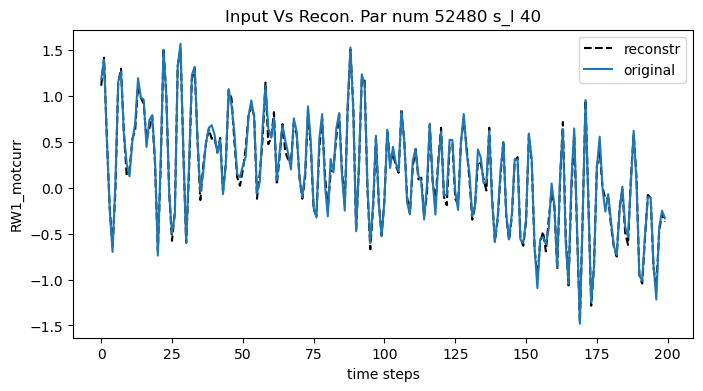

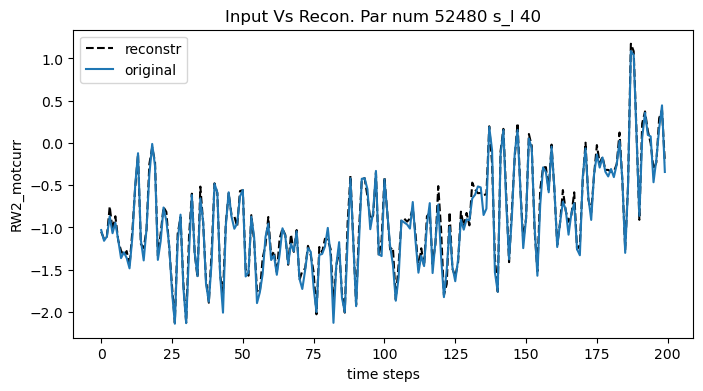

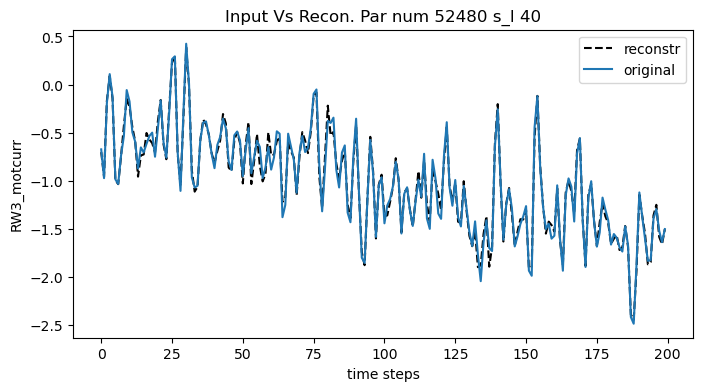

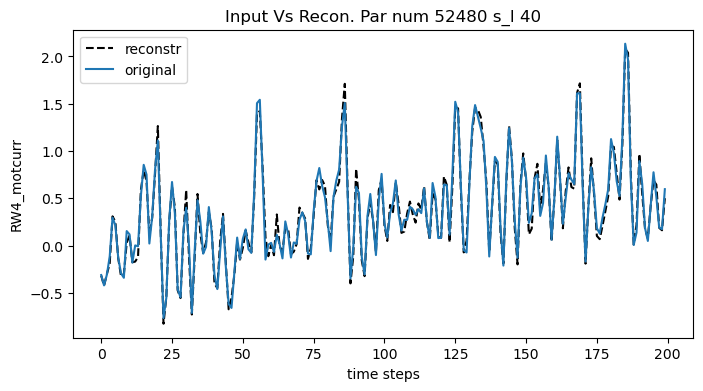

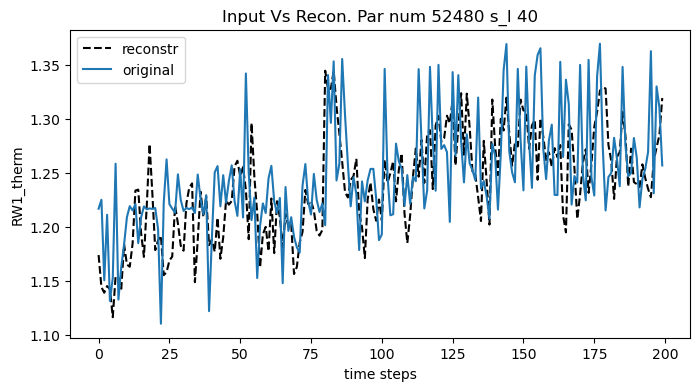

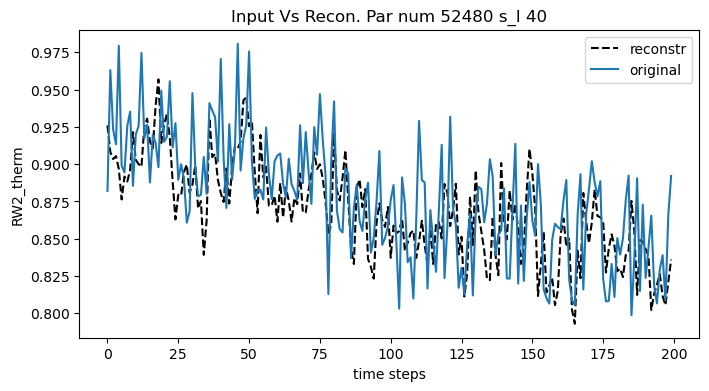

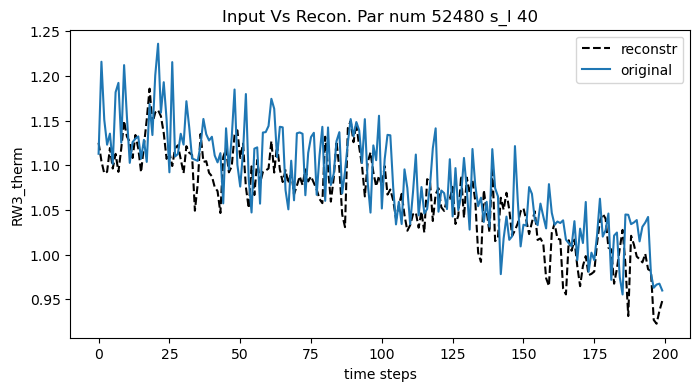

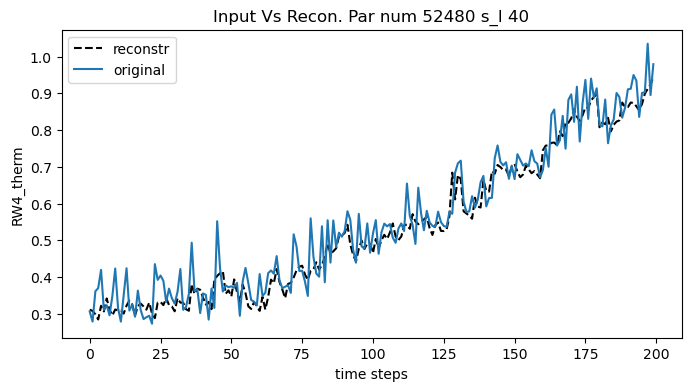

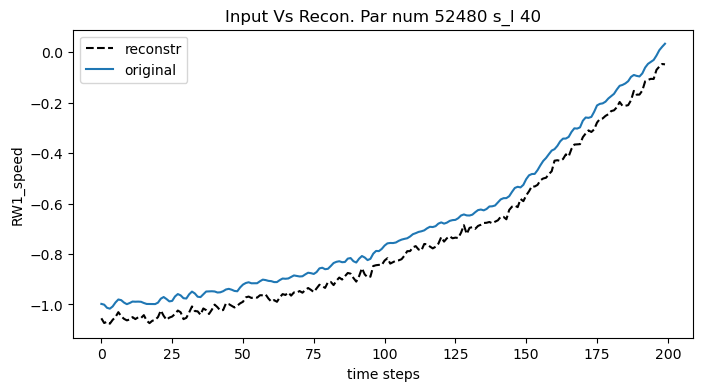

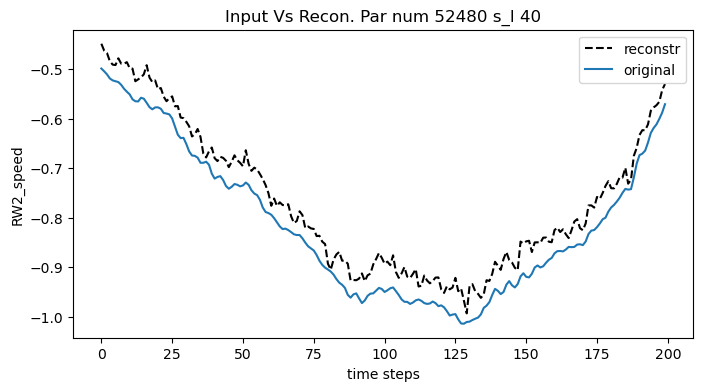

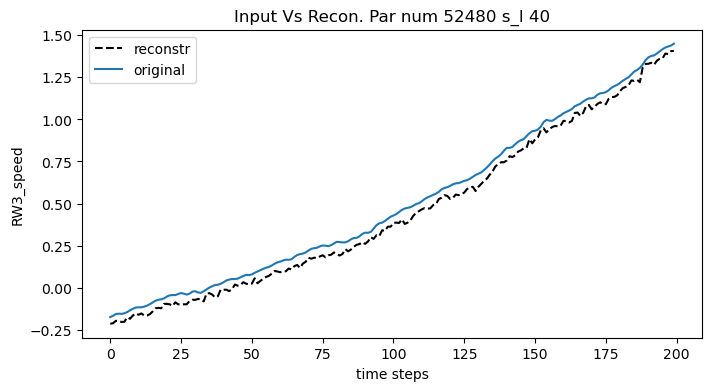

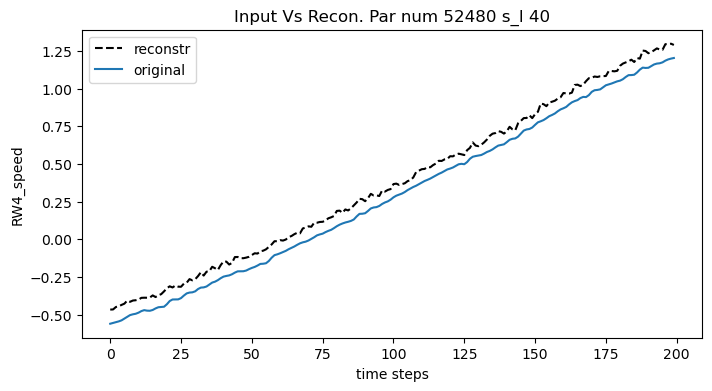

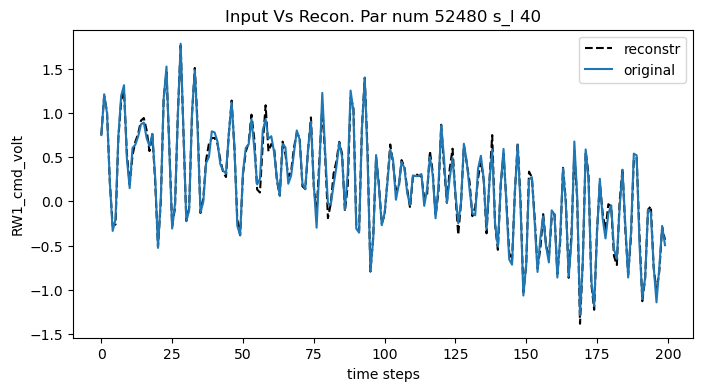

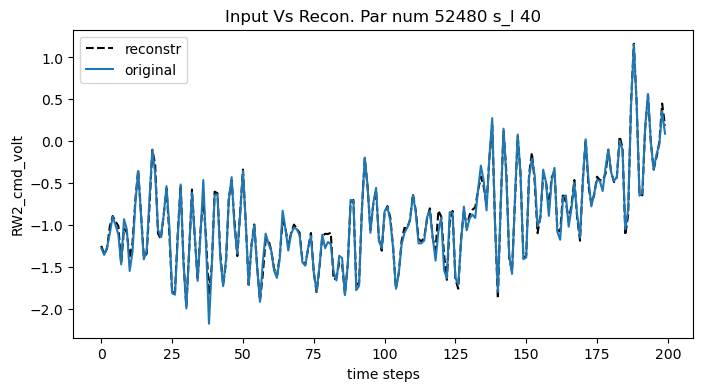

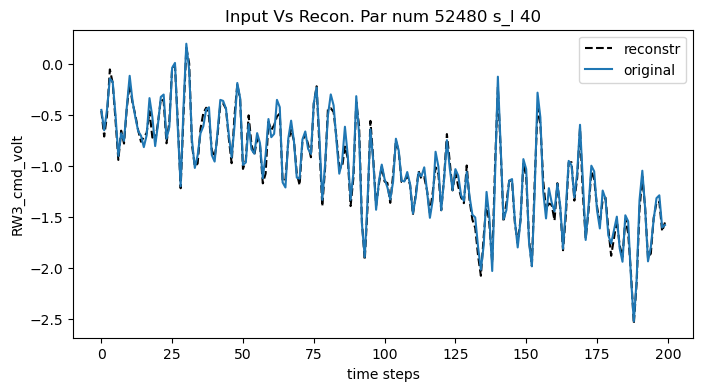

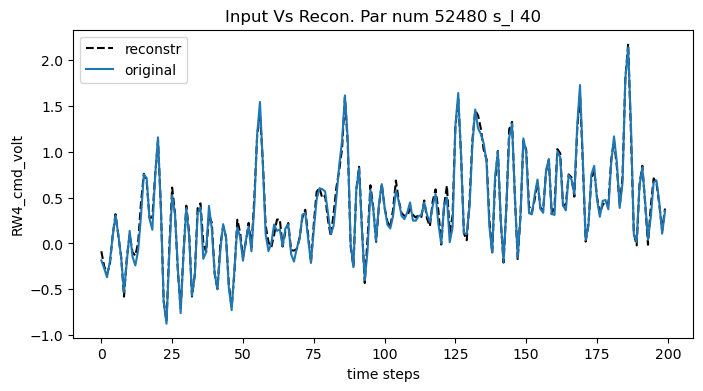

In [24]:
show_results(x, yo,cols,
    model_name, params_conf,
    par_nums, shift,num_batch,
    arch=architecture,
    save=False,)